In [1]:
import pandas as pd
import numpy as np

import os
import sys
import joblib

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ravdess = "/content/drive/MyDrive/Colab Notebooks/speech-emotion/dataset/ravdess/"
# ravdess_directory_list = os.listdir(Ravdess)
# for dir in ravdess_directory_list:
#   print(dir)

In [4]:
feature_df ="/content/drive/MyDrive/Colab Notebooks/speech-emotion/codes/feature-r-s.csv"
Model_path ="/content/drive/MyDrive/Colab Notebooks/speech-emotion/codes/ser-model.keras"
Scalar_path ="/content/drive/MyDrive/Colab Notebooks/speech-emotion/codes/scaler.pkl"
Encoder_path ="/content/drive/MyDrive/Colab Notebooks/speech-emotion/codes/encoder.pkl"

In [5]:
Features = pd.read_csv(feature_df)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310902e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116492e-06,8.190280e-06,0.000007,0.000005,4.245835e-07,neutral
1,0.313653,0.800385,0.818895,0.804210,0.803209,0.806036,0.707839,0.677258,0.725114,0.774453,...,4.860932e-05,4.813197e-05,4.904294e-05,4.882835e-05,5.054474e-05,5.394877e-05,0.000054,0.000051,4.680500e-05,neutral
2,0.188227,0.622090,0.699117,0.753257,0.721177,0.701753,0.682364,0.662857,0.686512,0.734021,...,8.577035e-07,9.576477e-07,7.733598e-07,5.233060e-07,3.593583e-07,9.267893e-07,0.000002,0.000001,7.754233e-08,neutral
3,0.323342,0.741108,0.752256,0.744445,0.732210,0.735576,0.684238,0.673684,0.699704,0.733065,...,1.982246e-05,1.854489e-05,2.479384e-05,8.005070e-05,4.002139e-05,3.728482e-05,0.000040,0.000023,1.570475e-06,neutral
4,0.245723,0.762177,0.752817,0.740239,0.760381,0.728605,0.688684,0.695779,0.740507,0.709607,...,1.984320e-05,1.854303e-05,2.479240e-05,8.001704e-05,4.002284e-05,3.730103e-05,0.000040,0.000023,1.578377e-06,neutral


In [6]:
print(Features.shape[0])

5760


In [7]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [8]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [9]:
joblib.dump(encoder, Encoder_path)

['/content/drive/MyDrive/Colab Notebooks/speech-emotion/codes/encoder.pkl']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 162), (4320, 8), (1440, 162), (1440, 8))

In [11]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 162), (4320, 8), (1440, 162), (1440, 8))

In [12]:
joblib.dump(scaler, Scalar_path)

['/content/drive/MyDrive/Colab Notebooks/speech-emotion/codes/scaler.pkl']

In [13]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 162, 1), (4320, 8), (1440, 162, 1), (1440, 8))

In [14]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# Define the input
inputs = Input(shape=(x_train.shape[1], 1))

# First Conv + MaxPooling block
x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

# Second Conv + MaxPooling block
x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

# Third Conv + MaxPooling block
x = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.2)(x)

# Fourth Conv + MaxPooling block
x = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

# Flatten the feature maps
x = Flatten()(x)

# Fully connected layers
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(8, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 162, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 422ms/step - accuracy: 0.1706 - loss: 2.0312 - val_accuracy: 0.2521 - val_loss: 1.9535 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 415ms/step - accuracy: 0.2248 - loss: 1.9591 - val_accuracy: 0.2465 - val_loss: 1.8636 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.2639 - loss: 1.8669 - val_accuracy: 0.3368 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.2832 - loss: 1.8299 - val_accuracy: 0.3458 - val_loss: 1.7177 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.3068 - loss: 1.7446 - val_accuracy: 0.3688 - val_loss: 1.6731 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 392ms/step - accuracy: 0.3314 - loss: 1.7045 - val_accuracy: 0.3840 - val_loss: 1.6384 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 426ms/step - accuracy: 0.3724 - loss: 1.

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6146 - loss: 1.2724
Accuracy of our model on test data :  62.91666626930237 %


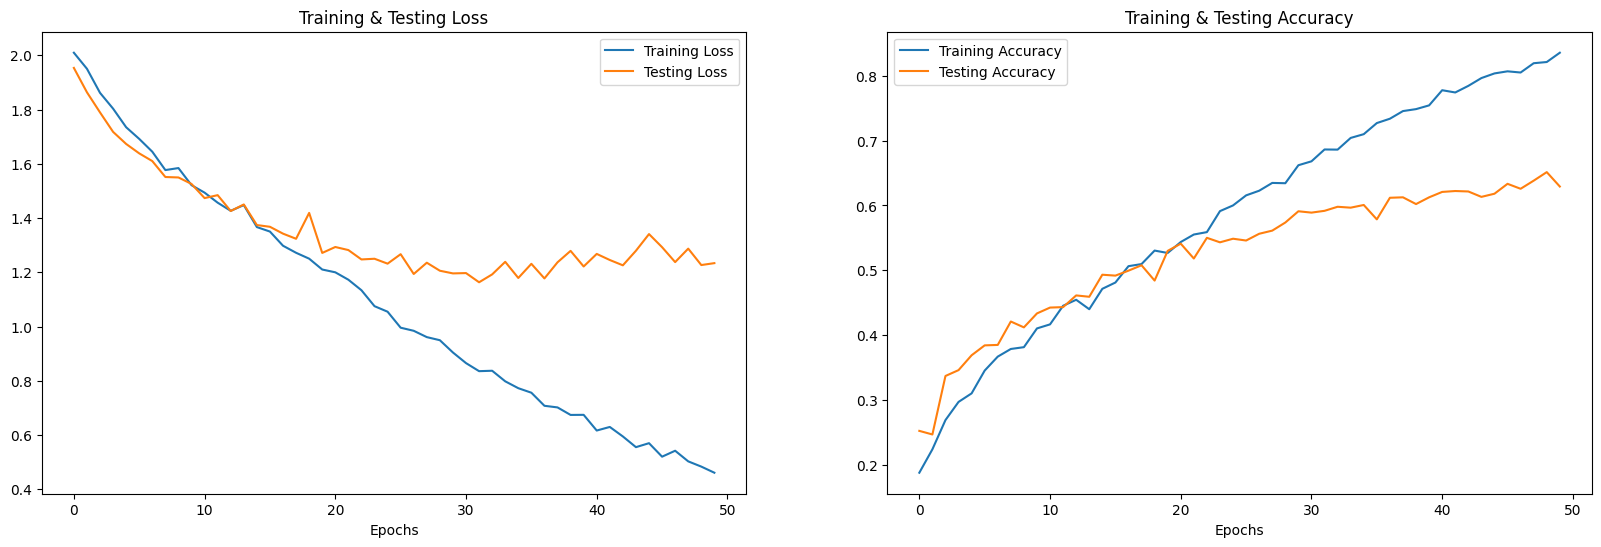

In [16]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [17]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [18]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,disgust,angry
1,disgust,disgust
2,happy,angry
3,happy,angry
4,fear,fear
5,angry,disgust
6,neutral,neutral
7,disgust,disgust
8,sad,sad
9,disgust,neutral


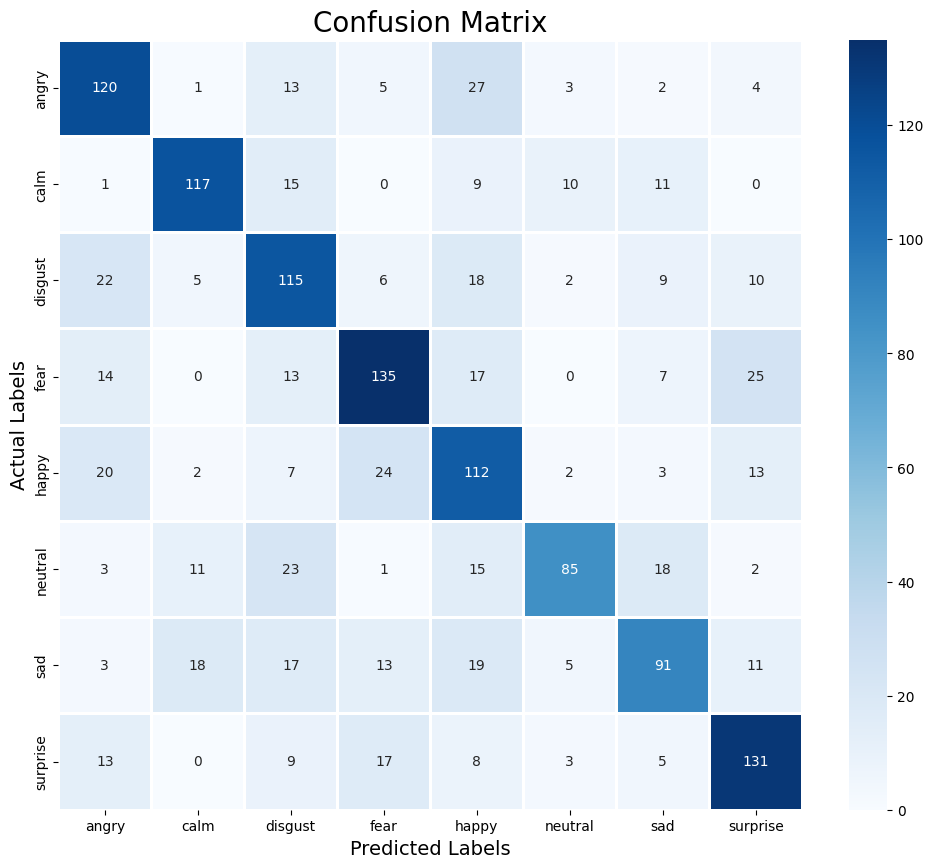

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [20]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.61      0.69      0.65       175
        calm       0.76      0.72      0.74       163
     disgust       0.54      0.61      0.58       187
        fear       0.67      0.64      0.66       211
       happy       0.50      0.61      0.55       183
     neutral       0.77      0.54      0.63       158
         sad       0.62      0.51      0.56       177
    surprise       0.67      0.70      0.69       186

    accuracy                           0.63      1440
   macro avg       0.64      0.63      0.63      1440
weighted avg       0.64      0.63      0.63      1440



In [21]:

model.save(Model_path)


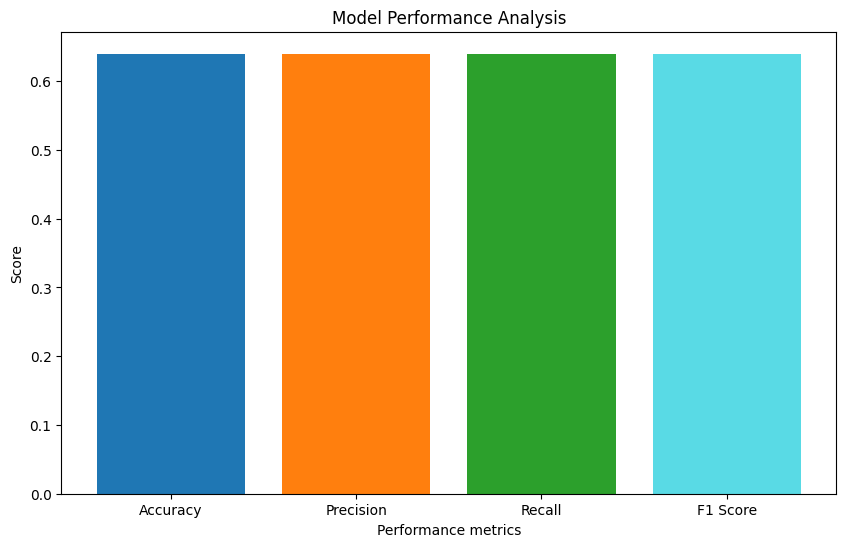

In [22]:
import matplotlib.pyplot as plt

# Data
emotions = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
counts = [0.64, 0.64, 0.64, 0.64]

# Assign different colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#59dae5']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color=colors)

# Add labels and title
plt.xlabel('Performance metrics')
plt.ylabel('Score')
plt.title('Model Performance Analysis')

# Show the plot
plt.show()

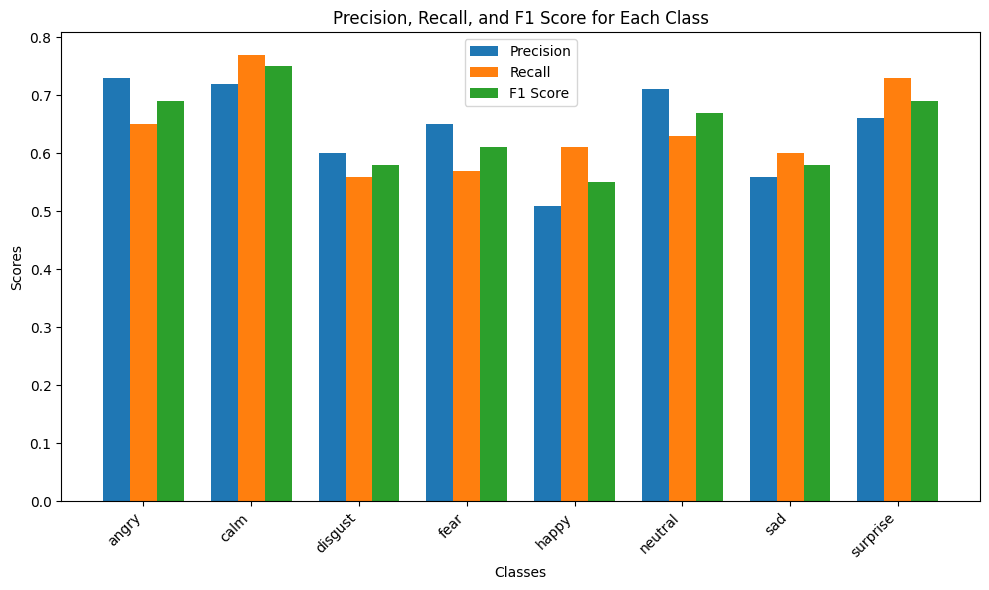

In [23]:
classes = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
precision = [0.73, 0.72, 0.60, 0.65, 0.51, 0.71, 0.56, 0.66]
recall = [0.65, 0.77, 0.56, 0.57, 0.61, 0.63, 0.60, 0.73]
f1_score = [0.69, 0.75, 0.58, 0.61, 0.55, 0.67, 0.58, 0.69]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the bar width and position
bar_width = 0.25
index = np.arange(len(classes))

# Plotting the bars
bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision')
bar2 = ax.bar(index, recall, bar_width, label='Recall')
bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1 Score')

# Add labels, title and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for Each Class')
ax.set_xticks(index)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()